# Zonal Salinity Bias
 
 Note that:
 * 0.1 degree case only processes 12 files at a time - should do more when we can.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
from dask.distributed import Client, progress

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

netcdf_index loaded.
Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [3]:
client = Client('tcp://10.0.64.16:8786', local_dir='/local/g40/amh157')
client

Client Scheduler: tcp://10.0.64.16:8786 Dashboard: http://10.0.64.16:8787/status,Cluster Workers: 6 Cores: 6 Memory: 24.00 GB


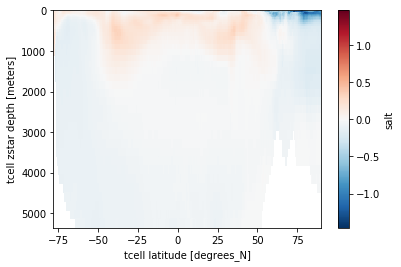

In [5]:
ekey='1deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']

salt_10 = cc.get_nc_variable(expt, 'ocean.nc', 'salt',
                        chunks={'st_ocean': None}, n=n_files,
                        time_units=time_units, offset=offset).mean('time')
salt_WOA13_10 = cc.get_nc_variable('woa13/10_KDS50', 'woa13_ts_??_mom10.nc', 'salt').mean('time')
#salt_WOA13_10 = cc.get_nc_variable('woa13/10_KDS50', 'ocean_temp_salt.res.nc', 'salt').mean('time')
# hacky renaming of variables so we can use as a dask array -- there's probably an elegant way to do this
salt_WOA13_10 = salt_WOA13_10.rename({'GRID_Y_T': 'yt_ocean', 'GRID_X_T': 'xt_ocean', 'ZT': 'st_ocean'})
salt_WOA13_10['st_ocean'] = salt_10.st_ocean
salt_WOA13_10['xt_ocean'] = salt_10.xt_ocean
salt_WOA13_10['yt_ocean'] = salt_10.yt_ocean

salt_anom_10 = salt_10 - salt_WOA13_10
zonal_salt_anom_10 = salt_anom_10.mean('xt_ocean')
zonal_salt_anom_10.load()

IPython.display.clear_output()

zonal_salt_anom_10.plot(yincrease=False)

In [ ]:
ekey='025deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']

salt_025 = cc.get_nc_variable(expt, 'ocean.nc', 'salt',
                        chunks={'st_ocean': None}, n=n_files,
                        time_units=time_units, offset=offset).mean('time')
salt_WOA13_025 = cc.get_nc_variable('woa13/025_KDS50', 'woa13_ts_??_mom025.nc', 'salt').mean('time')
# hacky renaming of variables so we can use as a dask array -- there's probably an elegant way to do this
salt_WOA13_025 = salt_WOA13_025.rename({'GRID_Y_T': 'yt_ocean', 'GRID_X_T': 'xt_ocean', 'ZT': 'st_ocean'})
salt_WOA13_025['st_ocean'] = salt_025.st_ocean
salt_WOA13_025['xt_ocean'] = salt_025.xt_ocean
salt_WOA13_025['yt_ocean'] = salt_025.yt_ocean

salt_anom_025 = salt_025 - salt_WOA13_025
zonal_salt_anom_025 = salt_anom_025.mean('xt_ocean')
zonal_salt_anom_025.load()

IPython.display.clear_output()

zonal_salt_anom_025.plot(yincrease=False)

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


In [ ]:
ekey='01deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']

chunks={'st_ocean':None, 'xt_ocean': 400, 'yt_ocean': 300}

salt_01 = cc.get_nc_variable(expt, 'ocean.nc', 'salt',
                        chunks=chunks, n=-12,
                        time_units=time_units, offset=offset).mean('time')

salt_WOA13_01 = cc.get_nc_variable('woa13/01', 'woa13_ts_??_mom01.nc', 'salt').mean('time')
# hacky renaming of variables so we can use as a dask array -- there's probably an elegant way to do this
salt_WOA13_01 = salt_WOA13_01.rename({'GRID_Y_T': 'yt_ocean', 'GRID_X_T': 'xt_ocean', 'ZT': 'st_ocean'})
salt_WOA13_01['st_ocean'] = salt_01.st_ocean
salt_WOA13_01['xt_ocean'] = salt_01.xt_ocean
salt_WOA13_01['yt_ocean'] = salt_01.yt_ocean

# force calculation and save to disk 
salt_WOA13_01.to_netcdf('/local/g40/amh157/salt_woa13.nc')

In [ ]:
# rechunk to match ocean.nc data
salt_WOA13_01 = xr.open_dataset('/local/g40/amh157/salt_woa13.nc', chunks=chunks).salt
salt_WOA13_01 = salt_WOA13_01.astype(np.float32)

salt_anom_01 = salt_01 - salt_WOA13_01
zonal_salt_anom_01 = salt_anom_01.mean('xt_ocean')
zonal_salt_anom_01.load()

IPython.display.clear_output()

zonal_salt_anom_01.plot(yincrease=False)

In [ ]:
mask = salt_025.copy()
mask = mask/mask                 ## This seems pretty dodgy to me, but it works!!
salt_WOA13_025 = salt_WOA13_025*mask
zonal_salt_WOA13_025 = salt_WOA13_025.mean('xt_ocean')
zonal_salt_WOA13_025.load()

zonal_salt_WOA13_025.plot(yincrease=False)

In [ ]:
plt.figure(figsize=(12,8))
clev=np.arange(-.8,.81,0.02)
    
plt.subplot(221)
p1=zonal_salt_anom_10.plot.contourf(cmap=cm.cm.balance,levels=clev,yincrease=False,add_colorbar=False)
plt.xlabel('')
plt.ylabel('depth (m)')
plt.title('(a) ACCESS-OM2')

plt.subplot(222)
p2=zonal_salt_anom_025.plot.contourf(cmap=cm.cm.balance,levels=clev,yincrease=False,add_colorbar=False)
plt.xlabel('')
plt.ylabel('')
plt.title('(b) ACCESS-OM2-025')

plt.subplot(223)
p3=zonal_salt_anom_01.plot.contourf(cmap=cm.cm.balance,levels=clev,yincrease=False,add_colorbar=False)
plt.xlabel('latitude (°N)')
plt.ylabel('depth (m)')
plt.title('(c) ACCESS-OM2-01')

plt.subplot(224)
p4=zonal_salt_WOA13_025.plot.contourf(cmap=cm.cm.haline,levels=np.arange(33,35.81,0.1),yincrease=False,add_colorbar=False)
plt.xlabel('latitude (°N)')
plt.ylabel('')
plt.title('(d) WOA13')

ax1 = plt.axes([0.94,0.55,0.01,0.33])
cb = plt.colorbar(p1,cax=ax1,orientation='vertical',extend='both')
#ax1.xaxis.set_label_position("top")
cb.ax.set_xlabel('Salt bias (g/kg)')

ax2 = plt.axes([0.94,0.13,0.01,0.33])
cb = plt.colorbar(p4,cax=ax2,orientation='vertical',extend='both')
#ax1.xaxis.set_label_position("top")
cb.ax.set_xlabel('Salt (g/kg)')

savefigure('zonal_salt_bias')